In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

In [2]:
# Assuming 'category_data' is your DataFrame containing data for a specific product and category_code
# Let's start with encoding categorical variables if needed


In [3]:
import warnings


In [4]:
warnings.filterwarnings('ignore')

In [5]:
# Load the datasets
oct_df = pd.read_csv('/data/CausalTrial/2019-Oct.csv')  # Update the path to your October dataset
nov_df = pd.read_csv('/data/CausalTrial/2019-Nov.csv')  # Update the path to your November dataset


In [6]:
# Combine the data
data = pd.concat([oct_df, nov_df])

In [7]:
del(oct_df)
del(nov_df)

In [8]:
data.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-10-01 00:00:00 UTC,view,44600062,2103807459595387724,NaN,shiseido,35.79,541312140,72d76fde-8bb3-4e00-8c23-a032dfed738c
1,2019-10-01 00:00:00 UTC,view,3900821,2053013552326770905,appliances.environment.water_heater,aqua,33.20,554748717,9333dfbd-b87a-4708-9857-6336556b0fcc
2,2019-10-01 00:00:01 UTC,view,17200506,2053013559792632471,furniture.living_room.sofa,NaN,543.10,519107250,566511c2-e2e3-422b-b695-cf8e6e792ca8
3,2019-10-01 00:00:01 UTC,view,1307067,2053013558920217191,computers.notebook,lenovo,251.74,550050854,7c90fc70-0e80-4590-96f3-13c02c18c713
4,2019-10-01 00:00:04 UTC,view,1004237,2053013555631882655,electronics.smartphone,apple,1081.98,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d


In [9]:
data.replace([np.inf, -np.inf], np.nan, inplace=True)

In [10]:
data.dropna(inplace=True)

In [11]:
data.isnull().sum()

event_time       0
event_type       0
product_id       0
category_id      0
category_code    0
brand            0
price            0
user_id          0
user_session     0
dtype: int64

In [12]:
# Step 1: Filter the dataset to include only purchase events
data['is_purchase'] = data['event_type'].apply(lambda x: 1 if x == 'purchase' else 0)

In [13]:
# Step 2: Frequency encoding for categorical variables
# Calculate the frequency of each category in 'category_code'
frequency_encoding_category = data['category_code'].value_counts(normalize=True)
data['category_code_encoded'] = data['category_code'].map(frequency_encoding_category)

# Calculate the frequency of each category in 'brand'
frequency_encoding_brand = data['brand'].value_counts(normalize=True)
data['brand_encoded'] = data['brand'].map(frequency_encoding_brand)

In [14]:
data.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,is_purchase,category_code_encoded,brand_encoded
1,2019-10-01 00:00:00 UTC,view,3900821,2053013552326770905,appliances.environment.water_heater,aqua,33.20,554748717,9333dfbd-b87a-4708-9857-6336556b0fcc,0,0.004947,0.000499
3,2019-10-01 00:00:01 UTC,view,1307067,2053013558920217191,computers.notebook,lenovo,251.74,550050854,7c90fc70-0e80-4590-96f3-13c02c18c713,0,0.048010,0.015517
4,2019-10-01 00:00:04 UTC,view,1004237,2053013555631882655,electronics.smartphone,apple,1081.98,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d,0,0.405518,0.150131
5,2019-10-01 00:00:05 UTC,view,1480613,2053013561092866779,computers.desktop,pulser,908.62,512742880,0d0d91c2-c9c2-4e81-90a5-86594dec0db9,0,0.015309,0.003101
8,2019-10-01 00:00:10 UTC,view,28719074,2053013565480109009,apparel.shoes.keds,baden,102.71,520571932,ac1cd4e5-a3ce-4224-a2d7-ff660a105880,0,0.011340,0.005754


In [17]:
# Ensure the data is sorted by product_id and time (event_time)
data = data.sort_values(by=['product_id', 'event_time'])

In [18]:
# Calculate the difference in price for each product
data['price_diff'] = data.groupby('product_id')['price'].diff()

In [19]:
# Define a threshold for considering a price change significant (e.g., > 1% change)
price_change_threshold = 0.01

In [20]:
# Identify the first date when a significant price change occurred
data['price_change'] = (data['price_diff'].abs() > price_change_threshold * data['price'].shift(1)).astype(int)

In [21]:
# Identify the first date of a significant price change for each product_id
first_price_change = data[data['price_change'] == 1].groupby('product_id')['event_time'].min().reset_index()

In [22]:
# Rename the event_time column to intervention_date
first_price_change.columns = ['product_id', 'intervention_date']

In [23]:
# Merge this with the original dataset
data = data.merge(first_price_change, on='product_id', how='left')

In [24]:
# Create the post_treatment indicator (1 if event_time >= intervention_date, 0 otherwise)
data['post_treatment'] = (data['event_time'] >= data['intervention_date']).astype(int)

In [24]:
# Treatment indicator remains as defined

In [35]:
data['time_period'] = pd.to_datetime(data['event_time']).dt.to_period('M').astype(str)

In [ ]:
#data['price'].median()

In [15]:
mean_value = data['price'].median()

In [16]:
mean_value

218.77

In [25]:
data['treatment'] = data['price'].apply(lambda x: 1 if x < mean_value else 0)

In [26]:
import statsmodels.formula.api as smf

In [36]:
# Apply the DiD model
did_model = smf.ols('is_purchase ~ treatment * post_treatment + C(time_period)', data=data).fit()
summary = did_model.summary()
print(summary)

                            OLS Regression Results                            
Dep. Variable:            is_purchase   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                 2.045e+04
Date:                Sun, 25 Aug 2024   Prob (F-statistic):               0.00
Time:                        12:23:23   Log-Likelihood:             4.1894e+07
No. Observations:            68650184   AIC:                        -8.379e+07
Df Residuals:                68650179   BIC:                        -8.379e+07
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

In [38]:
# Visualization for DiD
pre_treatment = data[data['post_treatment'] == 0]
post_treatment = data[data['post_treatment'] == 1]

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

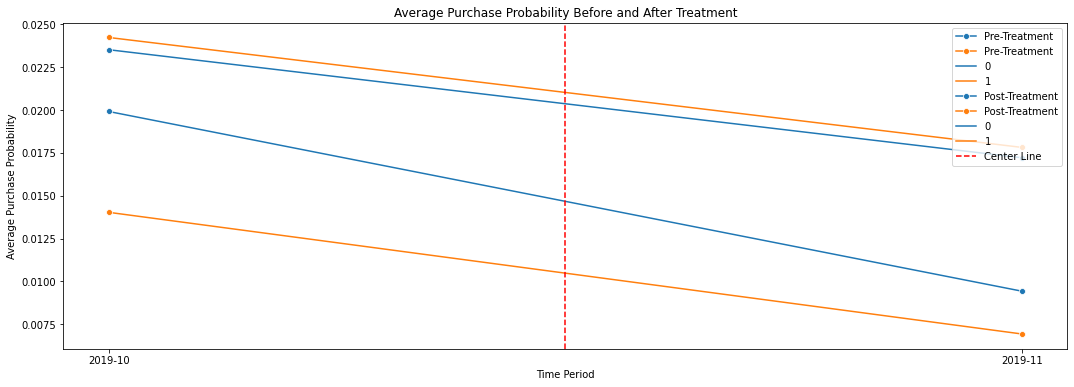

In [43]:
# Plot Average Purchase Probability Before and After Treatment
pre_avg = pre_treatment.groupby(['treatment', 'time_period']).is_purchase.mean().reset_index()
post_avg = post_treatment.groupby(['treatment', 'time_period']).is_purchase.mean().reset_index()



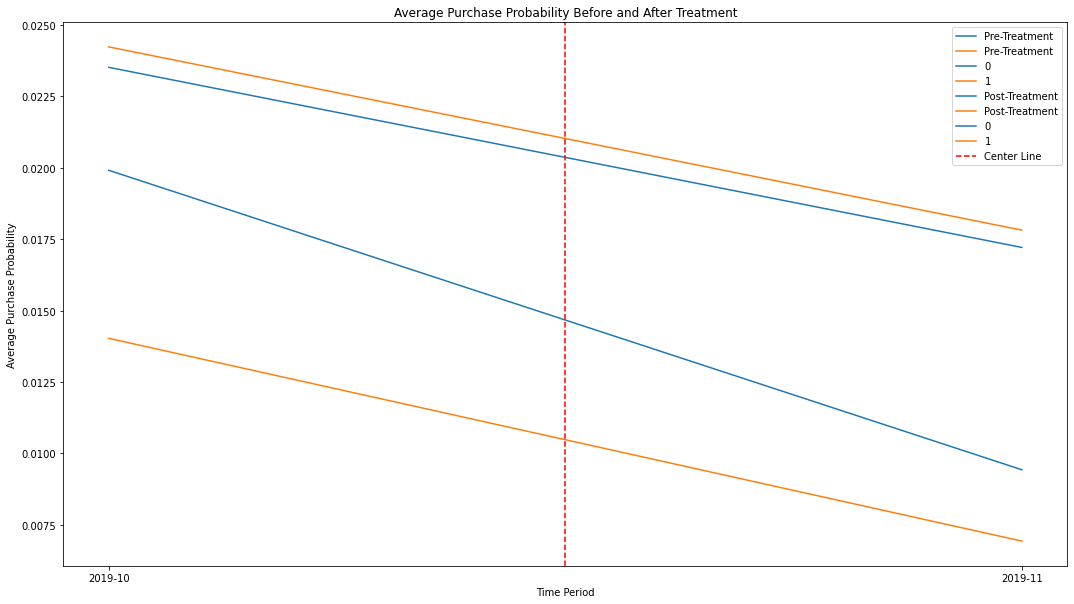

In [48]:
plt.figure(figsize=(18, 10))
sns.lineplot(x='time_period', y='is_purchase', hue='treatment', data=pre_avg,label='Pre-Treatment')
sns.lineplot(x='time_period', y='is_purchase', hue='treatment', data=post_avg, label='Post-Treatment')

# Adding a vertical line in the center of the plot area
#center_time_period = (pre_avg['time_period'].max() + post_avg['time_period'].min()) / 2
plt.axvline(x=0.5, color='red', linestyle='--', label='Center Line')

plt.title('Average Purchase Probability Before and After Treatment')
plt.xlabel('Time Period')
plt.ylabel('Average Purchase Probability')
# Moving the legend to the upper right corner 
plt.legend(loc='upper right')
plt.show()

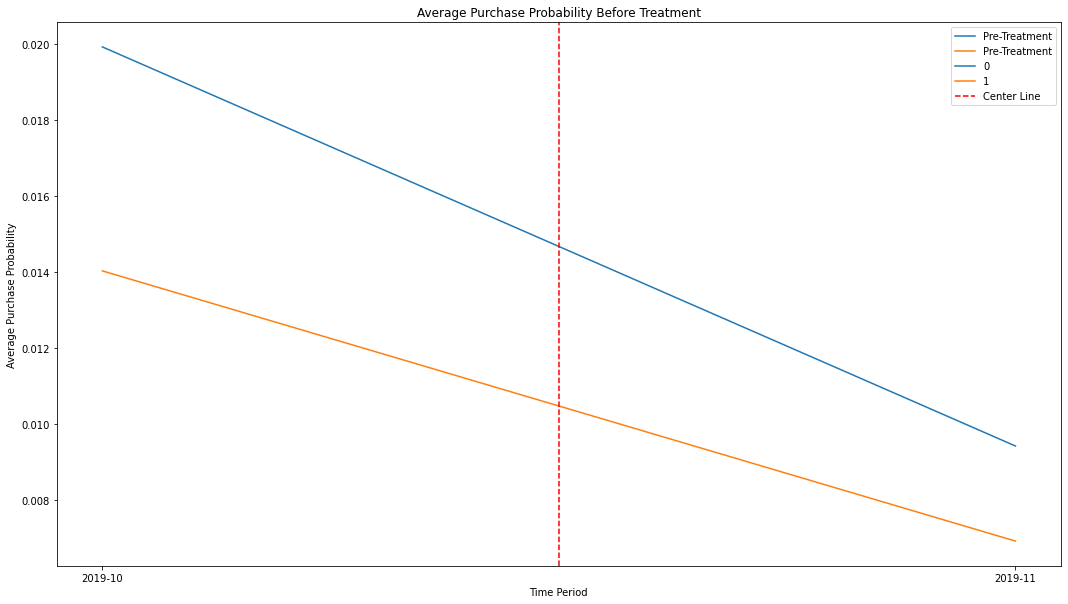

In [50]:
plt.figure(figsize=(18, 10))
sns.lineplot(x='time_period', y='is_purchase', hue='treatment', data=pre_avg,label='Pre-Treatment')
#sns.lineplot(x='time_period', y='is_purchase', hue='treatment', data=post_avg, label='Post-Treatment')

# Adding a vertical line in the center of the plot area
#center_time_period = (pre_avg['time_period'].max() + post_avg['time_period'].min()) / 2
plt.axvline(x=0.5, color='red', linestyle='--', label='Center Line')

plt.title('Average Purchase Probability Before Treatment')
plt.xlabel('Time Period')
plt.ylabel('Average Purchase Probability')
# Moving the legend to the upper right corner 
plt.legend(loc='upper right')
plt.show()

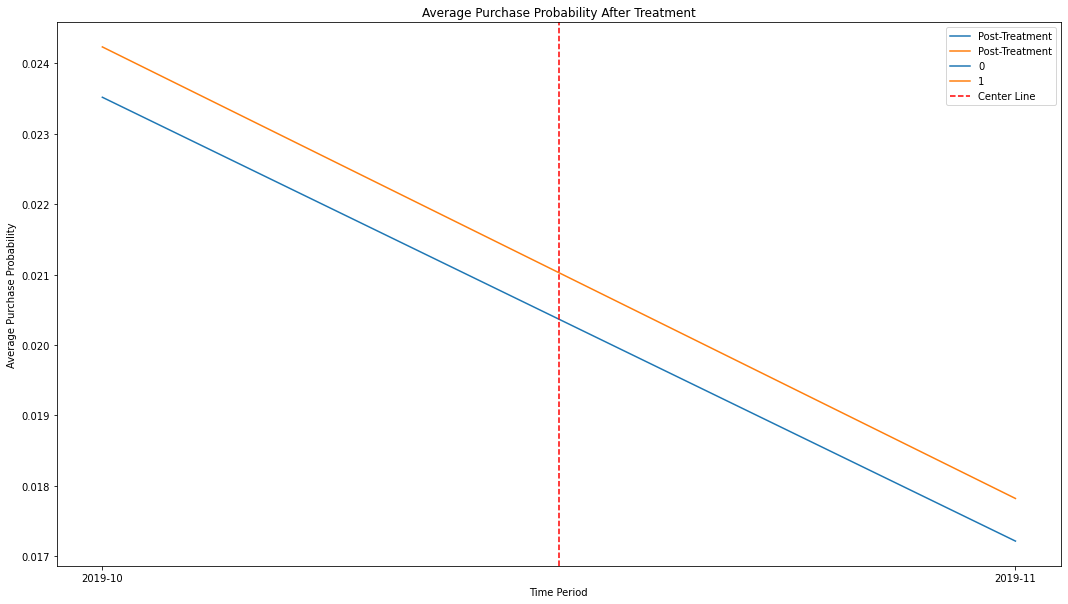

In [52]:
plt.figure(figsize=(18, 10))
#sns.lineplot(x='time_period', y='is_purchase', hue='treatment', data=pre_avg,label='Pre-Treatment')
sns.lineplot(x='time_period', y='is_purchase', hue='treatment', data=post_avg, label='Post-Treatment')

# Adding a vertical line in the center of the plot area
#center_time_period = (pre_avg['time_period'].max() + post_avg['time_period'].min()) / 2
plt.axvline(x=0.5, color='red', linestyle='--', label='Center Line')

plt.title('Average Purchase Probability After Treatment')
plt.xlabel('Time Period')
plt.ylabel('Average Purchase Probability')
# Moving the legend to the upper right corner 
plt.legend(loc='upper right')
plt.show()